In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [140]:
folder_image = '/home/sogangori/Downloads/water/'


In [149]:

class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()
        
        print('self.scales', self.scales)
        print('self.self._num_anchors', self._num_anchors)
        print('self._strides', self._strides)
        print('self._areas', self._areas)
        print('self._anchor_dims', len(self._anchor_dims))
        for anchor_dim in self._anchor_dims:
            print('dim', anchor_dim.shape)#(1, 1, 9, 2)
            print(anchor_dim[0,0].numpy().astype(np.int).reshape([-1]))
            #for n in range(self._num_anchors):
                #print(anchor_dim[0,0,n].numpy())

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:#5
            anchor_dims = []
            for ratio in self.aspect_ratios:#3
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:#3
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        print('_get_anchors', 'level',level, feature_height.numpy(), feature_width.numpy())
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        anchors_2d = tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4])
        return anchors

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        #return tf.concat(anchors, axis=0)
        return anchors

In [151]:
anchor_box = AnchorBox()
anchor_box.aspect_ratios, anchor_box.scales

self.scales [1, 1.2599210498948732, 1.5874010519681994]
self.self._num_anchors 9
self._strides [8, 16, 32, 64, 128]
self._areas [1024.0, 4096.0, 16384.0, 65536.0, 262144.0]
self._anchor_dims 5
dim (1, 1, 9, 2)
[22 45 28 57 35 71 32 32 40 40 50 50 45 22 57 28 71 35]
dim (1, 1, 9, 2)
[ 45  90  57 114  71 143  64  64  80  80 101 101  90  45 114  57 143  71]
dim (1, 1, 9, 2)
[ 90 181 114 228 143 287 128 128 161 161 203 203 181  90 228 114 287 143]
dim (1, 1, 9, 2)
[181 362 228 456 287 574 256 256 322 322 406 406 362 181 456 228 574 287]
dim (1, 1, 9, 2)
[ 362  724  456  912  574 1149  512  512  645  645  812  812  724  362
  912  456 1149  574]


([0.5, 1.0, 2.0], [1, 1.2599210498948732, 1.5874010519681994])

In [167]:
img_h = 128*6
img_w = img_h
anchor_boxes = anchor_box.get_anchors(img_h, img_w)
anchor_size = [(np.ceil(img_h / 2 ** i),
                np.ceil(img_w / 2 ** i))
            for i in range(3, 8)        ]
anchor_size = np.array(anchor_size).astype(np.int)
anchor_size

_get_anchors level 3 96.0 96.0
_get_anchors level 4 48.0 48.0
_get_anchors level 5 24.0 24.0
_get_anchors level 6 12.0 12.0
_get_anchors level 7 6.0 6.0


array([[96, 96],
       [48, 48],
       [24, 24],
       [12, 12],
       [ 6,  6]])

In [9]:
128*6, 128*6/2, 128*6/2/2, 128*6/2/2/2, 128*6/2/2/2/2, 128*6/2/2/2/2/2, 128*6/2/2/2/2/2/2, 128*6/2/2/2/2/2/2/2

(768, 384.0, 192.0, 96.0, 48.0, 24.0, 12.0, 6.0)

In [168]:
for anchor in anchor_boxes:
    # cx, cy, w, h
    print('anchor', anchor.shape, anchor[0,0,3].numpy())

anchor (96, 96, 9, 4) [ 4.  4. 32. 32.]
anchor (48, 48, 9, 4) [ 8.  8. 64. 64.]
anchor (24, 24, 9, 4) [ 16.  16. 128. 128.]
anchor (12, 12, 9, 4) [ 32.  32. 256. 256.]
anchor (6, 6, 9, 4) [ 64.  64. 512. 512.]


In [169]:
def gen_grid(h, w, row, col):
    arr = np.zeros((h, w), np.uint8)
    stride_h = h//row
    stride_w = w//col
    arr[::stride_h] = 255
    arr[:, ::stride_h] = 255
    return arr

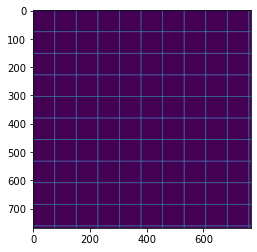

In [170]:
grid = gen_grid(img_h, img_w, 10, 10)
plt.imshow(grid)

In [171]:
from glob import glob
jpg_list = glob(folder_image+'/*')
jpg_list

['/home/sogangori/Downloads/water/day45.jpg',
 '/home/sogangori/Downloads/water/night25.jpg']

In [172]:
image_sample = Image.open(jpg_list[0])
image_sample.size


(1920, 1080)

In [173]:
image_sample_resized = image_sample.resize((img_w, img_h))
image_sample_resized.size

(768, 768)

In [174]:
anchor_size[0,1]

96

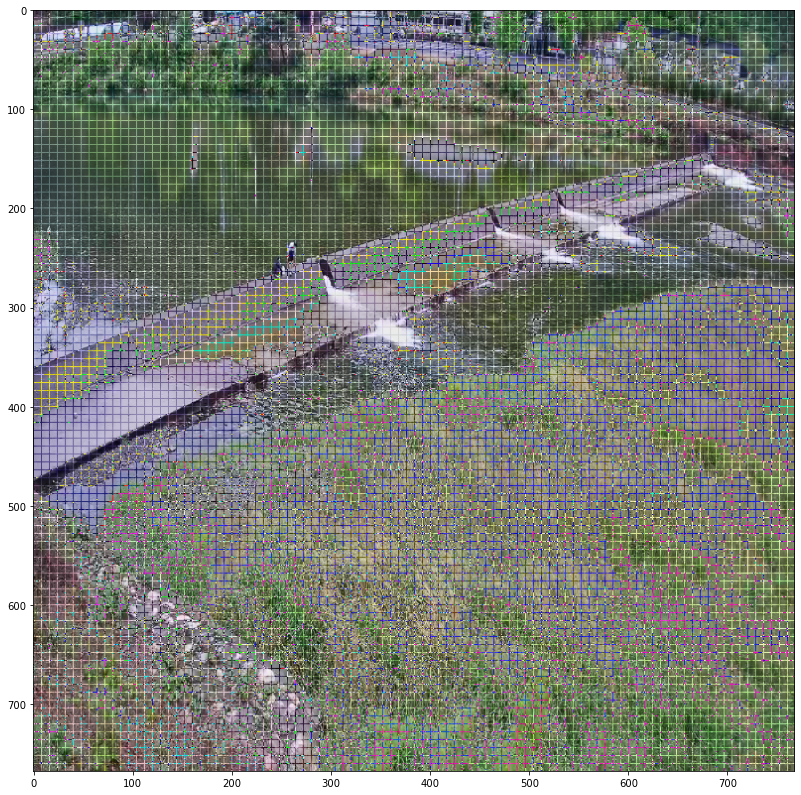

In [175]:
grid = gen_grid(img_h, img_w, anchor_size[0,0], anchor_size[0,1])
resize_arr = np.array(image_sample_resized)
image_grid_mix = resize_arr * (1 - np.expand_dims(grid,-1))
#image_grid_mix = np.concatenate((np.expand_dims(grid,-1), resize_arr[:,:,1:]), axis=-1)
plt.figure(figsize=(14,14))
plt.imshow(image_grid_mix)

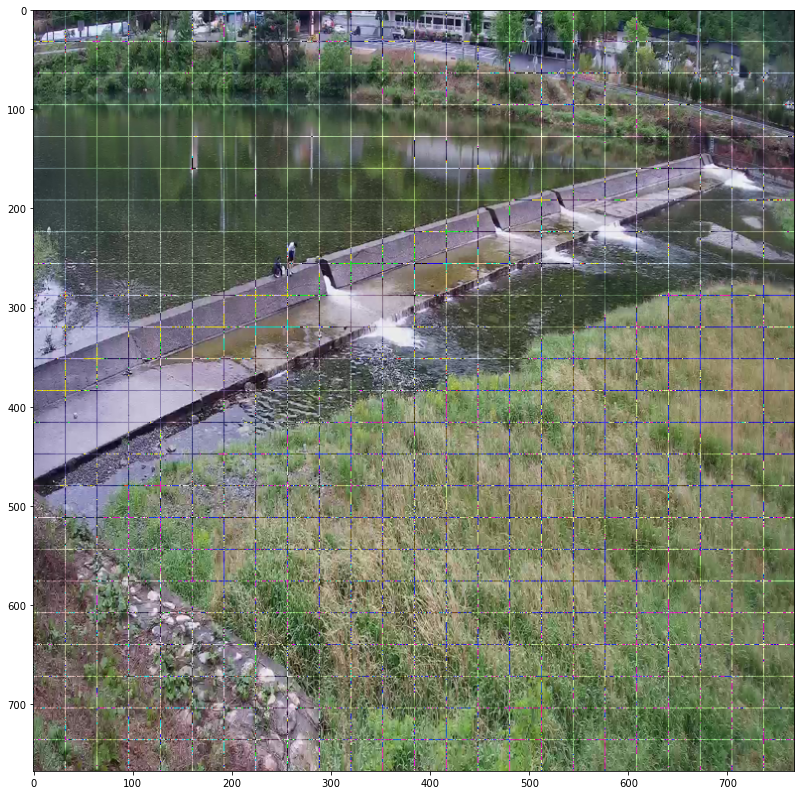

In [176]:
grid = gen_grid(img_h, img_w, anchor_size[2,0], anchor_size[2,1])
resize_arr = np.array(image_sample_resized)
image_grid_mix = resize_arr * (1 - np.expand_dims(grid,-1))
#image_grid_mix = np.concatenate((np.expand_dims(grid,-1), resize_arr[:,:,1:]), axis=-1)
plt.figure(figsize=(14,14))
plt.imshow(image_grid_mix)

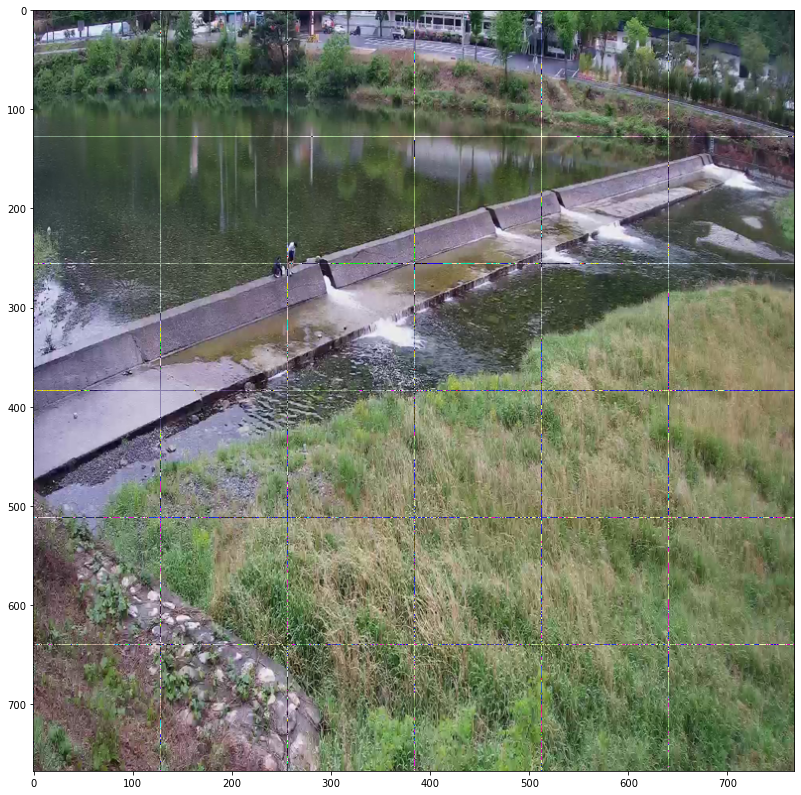

In [177]:
grid = gen_grid(img_h, img_w, anchor_size[-1,0], anchor_size[-1,1])
resize_arr = np.array(image_sample_resized)
image_grid_mix = resize_arr * (1 - np.expand_dims(grid,-1))
#image_grid_mix = np.concatenate((np.expand_dims(grid,-1), resize_arr[:,:,1:]), axis=-1)
plt.figure(figsize=(14,14))
plt.imshow(image_grid_mix)